# 당뇨병 예측 시스템 (실무형)



##  학습 목표
1. 전체 ML 파이프라인 구축
2. DataLoader를 사용한 배치 학습
3. Early Stopping 구현
4. Learning Rate Scheduler 활용
5. 모델 저장 및 로드
6. 실무 코드 구조


## 1. 패키지 설치

In [ ]:
# !pip install -q torch scikit-learn matplotlib pandas

## 2. 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes # 당뇨병
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json

np.random.seed(42)
torch.manual_seed(42)

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True

## 3. Config 클래스 (설정 관리)

In [2]:
class Config: # 기본 설정 관리
    def __init__(self):
        self.test_size = 0.2
        self.val_size = 0.2
        self.random_state = 42
        self.input_dim = 10
        self.hidden_dims = [64, 32, 16]
        self.dropout_rate = 0.3
        self.batch_size = 32
        self.num_epochs = 200
        self.learning_rate = 0.001
        self.weight_decay = 0.0001
        self.patience = 20 # early stop
        self.min_delta = 0.001
        self.scheduler_step_size = 30
        self.scheduler_gamma = 0.5

config = Config()
print('Config 생성 완료!')
print(f'Batch Size: {config.batch_size}')
print(f'Learning Rate: {config.learning_rate}')

Config 생성 완료!
Batch Size: 32
Learning Rate: 0.001


## 4. DataPreprocessor 클래스

In [3]:
class DataPreprocessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()

    def load_and_prepare_data(self): # 원본 데이터 --> train, test, val 데이터로 나누기
        diabetes = load_diabetes()
        X = diabetes.data
        y_regression = diabetes.target
        median = np.median(y_regression)
        y = (y_regression > median).astype(int)

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=self.config.test_size, stratify=y, random_state=self.config.random_state
        )
        # Train - Test 분류

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=self.config.val_size,
            stratify=y_train_val, random_state=self.config.random_state
        )
        # Train data set 을 Train - Validation 분류

        X_train = self.scaler.fit_transform(X_train)
        #fit_transform(X_train) 훈련하니깐 fit_transform 이야
        X_val = self.scaler.transform(X_val)
        X_test = self.scaler.transform(X_test)

        print('데이터 준비 완료')
        print(f'Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}')

        return X_train, X_val, X_test, y_train, y_val, y_test

    def create_dataloaders(self, X_train, X_val, X_test, y_train, y_val, y_test): # 데이터 로더 생성(여기서 배치 결정)
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train).view(-1, 1)
            # 파이토치가 2차원 구조 기대 (batch_size, features)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val),
            torch.FloatTensor(y_val).view(-1, 1)
        )
        test_dataset = TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test).view(-1, 1)
        )

        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.config.batch_size, shuffle=False)

        print(f'DataLoader 생성 완료 (Batch Size: {self.config.batch_size})')

        return train_loader, val_loader, test_loader

print('DataPreprocessor 클래스 정의 완료!')

# 파이토치 해주세요. 데이터를 텐서 데이터셋으로 변경해주시구요, 이 친구를 데이터로더에 올려주세요.

DataPreprocessor 클래스 정의 완료!


## 5. 데이터 준비 실행

In [6]:
preprocessor = DataPreprocessor(config)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.load_and_prepare_data()
train_loader, val_loader, test_loader = preprocessor.create_dataloaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

데이터 준비 완료
Train: 282, Val: 71, Test: 89
DataLoader 생성 완료 (Batch Size: 32)


## 6. 모델 클래스

In [7]:
class DiabetesClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(DiabetesClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self): # Linear 층을 He 초기화 하는 함수
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # he 초기화 (kaiming_normal_)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

model = DiabetesClassifier(
    input_dim=config.input_dim,
    hidden_dims=config.hidden_dims,
    dropout_rate=config.dropout_rate
)

print('모델 생성 완료!')
print(model)

모델 생성 완료!
DiabetesClassifier(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


## ⏱7. EarlyStopping 클래스

In [4]:
class EarlyStopping: # 과적합 방지
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

print('EarlyStopping 클래스 정의 완료!')

EarlyStopping 클래스 정의 완료!


## 8. Trainer 클래스

In [5]:
class Trainer:
    def __init__(self, model, config, device='cpu'):
        self.model = model.to(device)
        self.config = config
        self.device = device
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay #
        )
        self.scheduler = optim.lr_scheduler.StepLR( # lr를 단계적으로 낮춤
            self.optimizer,
            step_size=config.scheduler_step_size,
            gamma=config.scheduler_gamma
        )
        self.early_stopping = EarlyStopping(
            patience=config.patience,
            min_delta=config.min_delta
        )
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'learning_rate': []
        }

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch_X.size(0)
            predicted = (outputs >= 0.0).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        return total_loss / total, correct / total # 전체 평균 Loss, 정확도

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)

                total_loss += loss.item() * batch_X.size(0)
                predicted = (outputs >= 0.0).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        return total_loss / total, correct / total

    def fit(self, train_loader, val_loader):
        print('학습 시작...')

        for epoch in range(self.config.num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rate'].append(current_lr)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1:3d}/{self.config.num_epochs}] "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                      f"LR: {current_lr:.6f}")

            self.early_stopping(val_loss, self.model)
            if self.early_stopping.early_stop:
                print(f"Early Stopping at Epoch {epoch+1}")
                self.model.load_state_dict(self.early_stopping.best_model_state)
                break

        print('\n학습 완료!')

print('Trainer 클래스 정의 완료!')

Trainer 클래스 정의 완료!


## 9. 모델 학습 실행

In [11]:
trainer = Trainer(model, config)
trainer.fit(train_loader, val_loader)

학습 시작...
Epoch [ 10/200] Train Loss: 1.0159 | Train Acc: 0.6560 | Val Loss: 0.5942 | Val Acc: 0.6761 | LR: 0.001000
Epoch [ 20/200] Train Loss: 0.7646 | Train Acc: 0.7163 | Val Loss: 0.5622 | Val Acc: 0.6901 | LR: 0.001000
Epoch [ 30/200] Train Loss: 0.7952 | Train Acc: 0.7163 | Val Loss: 0.5424 | Val Acc: 0.7324 | LR: 0.000500
Epoch [ 40/200] Train Loss: 0.6863 | Train Acc: 0.6950 | Val Loss: 0.5401 | Val Acc: 0.7324 | LR: 0.000500
Epoch [ 50/200] Train Loss: 0.6049 | Train Acc: 0.7021 | Val Loss: 0.5333 | Val Acc: 0.7324 | LR: 0.000500
Epoch [ 60/200] Train Loss: 0.6544 | Train Acc: 0.7589 | Val Loss: 0.5232 | Val Acc: 0.7324 | LR: 0.000250
Epoch [ 70/200] Train Loss: 0.6253 | Train Acc: 0.7128 | Val Loss: 0.5233 | Val Acc: 0.7183 | LR: 0.000250
Epoch [ 80/200] Train Loss: 0.6318 | Train Acc: 0.6950 | Val Loss: 0.5214 | Val Acc: 0.7042 | LR: 0.000250
Epoch [ 90/200] Train Loss: 0.6868 | Train Acc: 0.6950 | Val Loss: 0.5163 | Val Acc: 0.7183 | LR: 0.000125
Epoch [100/200] Train Loss: 

## 10. 학습 결과 시각화

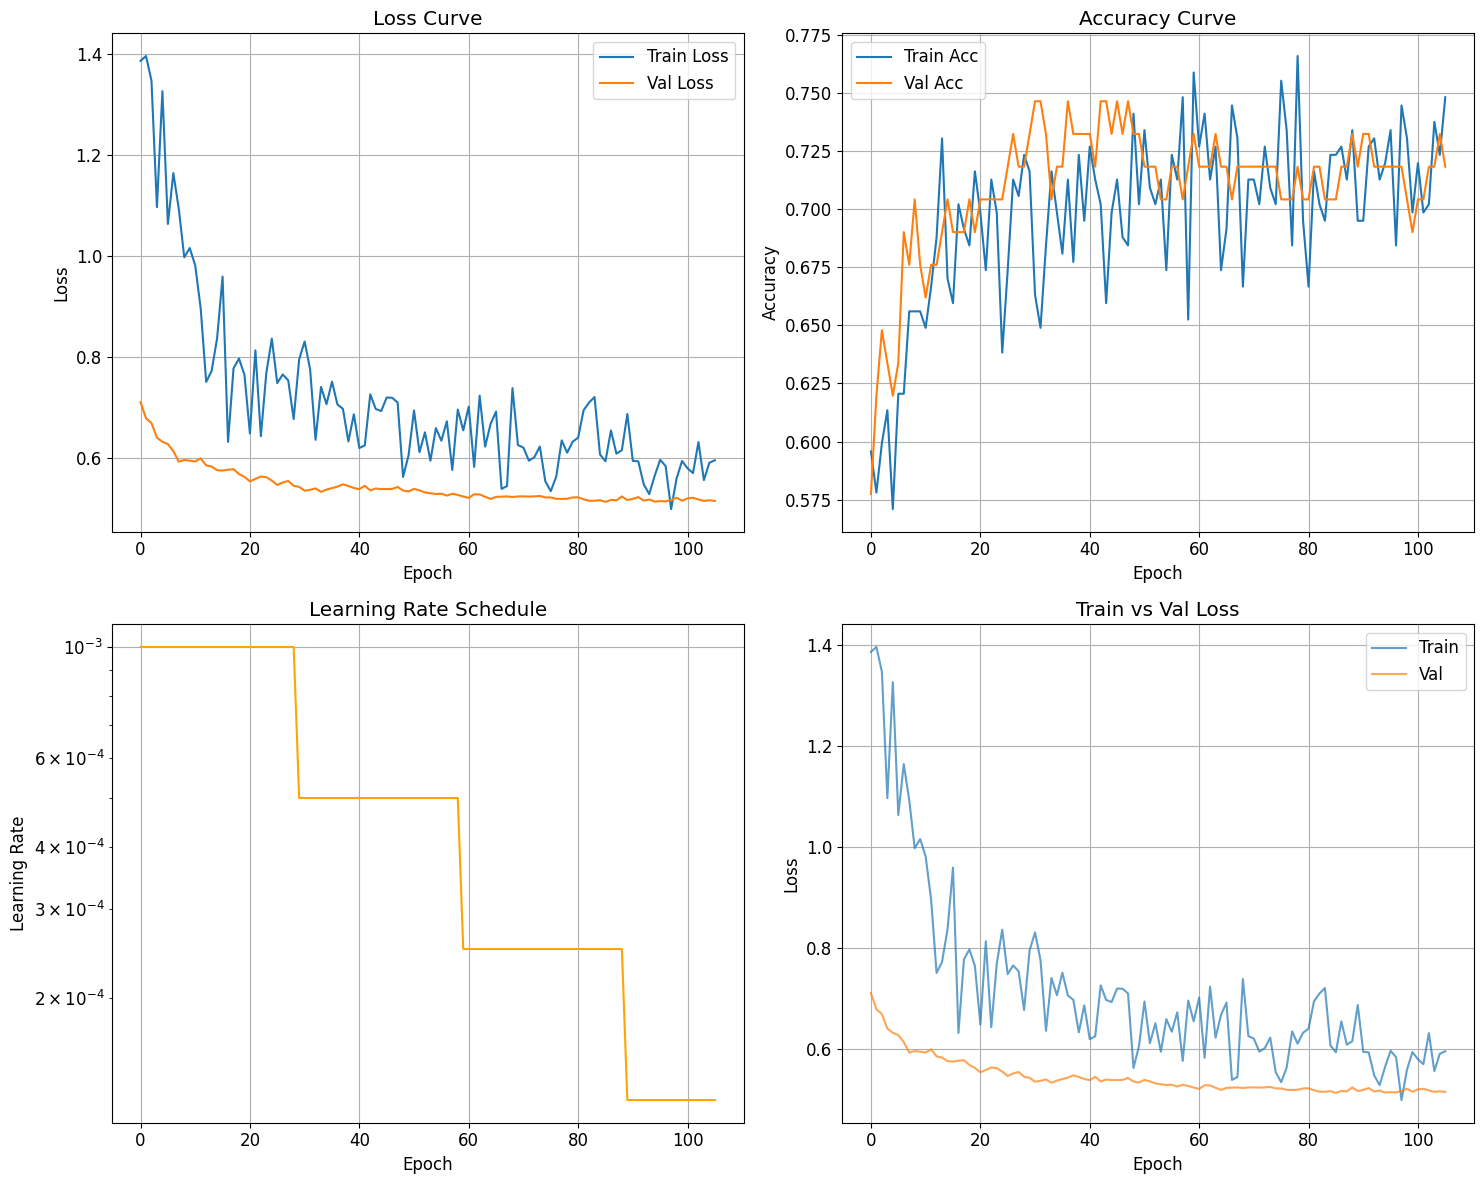

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(trainer.history['train_loss'], label='Train Loss')
axes[0, 0].plot(trainer.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curve')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(trainer.history['train_acc'], label='Train Acc')
axes[0, 1].plot(trainer.history['val_acc'], label='Val Acc')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy Curve')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(trainer.history['learning_rate'], color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

axes[1, 1].plot(trainer.history['train_loss'], label='Train', alpha=0.7)
axes[1, 1].plot(trainer.history['val_loss'], label='Val', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Train vs Val Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 11. 모델 평가

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probs = torch.sigmoid(outputs)
            preds = (outputs >= 0.0).float()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(batch_y.numpy())

    all_preds = np.array(all_preds).flatten()
    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels).flatten()

    return all_labels, all_preds, all_probs

all_labels, all_preds, all_probs = evaluate_model(model, test_loader)

print('[Classification Report]')
print(classification_report(all_labels, all_preds, target_names=['Low Risk', 'High Risk']))

cm = confusion_matrix(all_labels, all_preds)
print('\n[Confusion Matrix]')
print(f'              Predicted')
print(f'            Low  High')
print(f'Actual Low  {cm[0,0]:3d}  {cm[0,1]:3d}')
print(f'       High {cm[1,0]:3d}  {cm[1,1]:3d}')

auc = roc_auc_score(all_labels, all_probs)
print(f'\nAUC: {auc:.4f}')

[Classification Report]
              precision    recall  f1-score   support

    Low Risk       0.76      0.82      0.79        45
   High Risk       0.80      0.73      0.76        44

    accuracy                           0.78        89
   macro avg       0.78      0.77      0.77        89
weighted avg       0.78      0.78      0.77        89


[Confusion Matrix]
              Predicted
            Low  High
Actual Low   37    8
       High  12   32

AUC: 0.8364


## 12. Precision-Recall Curve

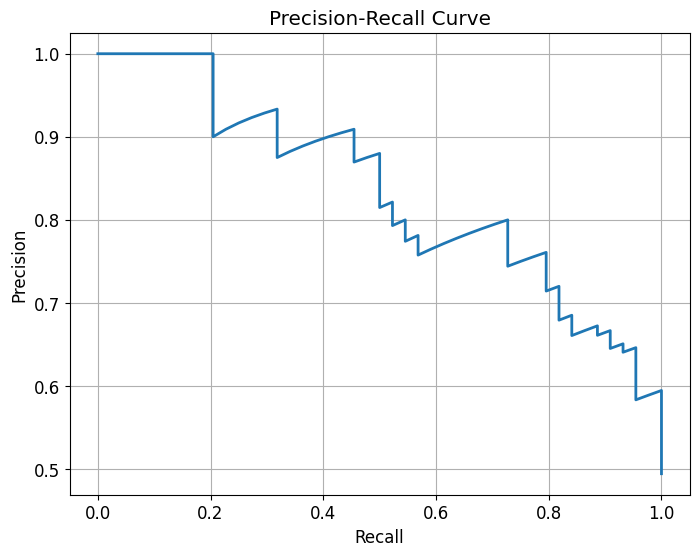

In [15]:
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
# eos